In [1]:
import tensorflow as tf
import os
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from sklearn.decomposition import PCA
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:


# Comments for documentation:
# - `import tensorflow as tf`: Import TensorFlow for building and training machine learning models.
# - `import os`: Import os module to interact with the operating system, e.g., reading file paths.
# - `import pandas as pd`: Import pandas for data manipulation and analysis.
# - `import numpy as np`: Import NumPy for numerical operations on arrays and matrices.
# - `import matplotlib as plt`: Import matplotlib for creating static, interactive, and animated visualizations in Python.
# - `from sklearn.metrics import mean_squared_error as mse`: Import mean_squared_error from sklearn for calculating the MSE metric for model evaluation.
# - `from sklearn.preprocessing import MinMaxScaler`: Import MinMaxScaler from sklearn for feature scaling by normalizing or standardizing features.
# - `import warnings`: Import warnings module to suppress warnings.
# - `import matplotlib.pyplot as plt`: Import pyplot from matplotlib for plotting graphs.
# - `warnings.filterwarnings('ignore')`: Set up warnings to ignore them to avoid clutter in the output.
# - `%matplotlib inline`: Enable inline plotting for Jupyter notebooks, making plots appear in the notebook itself.


In [3]:
df = pd.read_csv('timeseries.csv')
season = {'Winter':1,'Spring':2,'Summer':3,'Autumn':4}

In [4]:
df = df[:96431:]
df.index = pd.to_datetime(df['time'], format='%Y%m%d:%H%M')
df['G(i)'] = pd.to_numeric(df['G(i)'], errors='coerce')

day  = 60 * 60 * 24
year =  365.2425 * day
month = 30 * day

df["Seconds"] = df.index.map(pd.Timestamp.timestamp)
df ["day sin"] = np.sin(df['Seconds'] * ( 2 * np.pi /day))
df ["day cos"] = np.cos(df['Seconds'] * ( 2 * np.pi /day))
# df ["year sin"] = np.sin(df['Seconds'] * ( 2 * np.pi /year))
# df ["year cos"] = np.cos(df['Seconds'] * ( 2 * np.pi /year))

# 1971
df = df.drop(["Seconds"], axis = 1)

# Check for any NaN values after conversion
# print("NaN values in G(i):", df['G(i)'].isna().sum())
df= df[df['G(i)'] > 10]

def get_season(month):
    if month in [12, 1, 2]:
        return season['Winter']
    elif month in [3, 4, 5]:
        return season['Spring']
    elif month in [6, 7, 8]:
        return season['Summer']
    elif month in [9, 10, 11]:
        return season['Autumn']

# Apply the function to create the season column
df['Season'] = df.index.month.map(get_season)

# Load data into DataFrame
data = df.copy()
data.drop(['Int'], axis = 1,inplace=True)

# Ensure 'time' column is of string type
data['time'] = data['time'].astype(str)

# Validate 'time' column format and filter rows with valid datetime-like strings
valid_time_format = r'^\d{8}:\d{4}$'
data = data[data['time'].str.match(valid_time_format, na=False)]

# Convert 'time' column to datetime
data['time'] = pd.to_datetime(data['time'], format='%Y%m%d:%H%M')

# Set 'time' as the index
data.set_index('time', inplace=True)

# Convert all columns to numeric, coercing errors to NaN
data = data.apply(pd.to_numeric, errors='coerce')

# Handle missing values by filling with the mean of each column
data.fillna(data.mean(), inplace=True)

# print(data.describe())

# Initialize MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

# Fit and transform the data
scaled_data = scaler.fit_transform(data)

# Create a new DataFrame with scaled data, preserving column names and index
scaled_df = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)

# Display the first few rows and basic statistics to confirm
# print(scaled_df.head())


print(scaled_df.head(15))
data=scaled_df


                         G(i)     H_sun       T2m     WS10m   day sin  \
time                                                                    
2010-01-01 04:07:00  0.071332  0.006303  0.124001  0.317957  0.931337   
2010-01-01 05:07:00  0.369032  0.159829  0.183397  0.283361  0.984864   
2010-01-01 06:07:00  0.586913  0.304317  0.320250  0.283361  1.000000   
2010-01-01 07:07:00  0.749934  0.433107  0.449114  0.283361  0.975715   
2010-01-01 08:07:00  0.854851  0.534190  0.516846  0.273476  0.913663   
2010-01-01 09:07:00  0.895757  0.588417  0.553317  0.204283  0.818074   
2010-01-01 10:07:00  0.864754  0.578904  0.595693  0.125206  0.695461   
2010-01-01 11:07:00  0.766906  0.509335  0.616534  0.046129  0.554181   
2010-01-01 12:07:00  0.605511  0.398621  0.623480  0.034596  0.403861   
2010-01-01 13:07:00  0.404155  0.264479  0.613407  0.079077  0.254745   
2010-01-01 14:07:00  0.173677  0.116899  0.589788  0.102142  0.116995   
2010-01-02 04:07:00  0.006421  0.005470  0.146231  

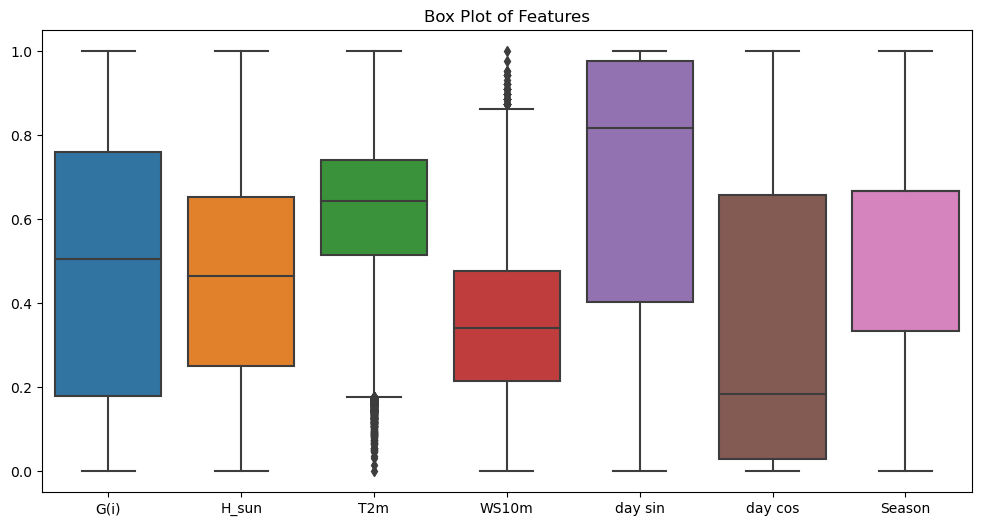

In [5]:
# Box Plots
plt.figure(figsize=(12, 6))
sns.boxplot(data=data)
plt.title('Box Plot of Features')
plt.show()

                         G(i)     H_sun       T2m     WS10m   day sin  \
time                                                                    
2010-01-01 04:00:00  0.071332  0.006303  0.124001  0.317957  0.931337   
2010-01-01 05:00:00  0.369032  0.159829  0.183397  0.283361  0.984864   
2010-01-01 06:00:00  0.586913  0.304317  0.320250  0.283361  1.000000   
2010-01-01 07:00:00  0.749934  0.433107  0.449114  0.283361  0.975715   
2010-01-01 08:00:00  0.854851  0.534190  0.516846  0.273476  0.913663   
2010-01-01 09:00:00  0.895757  0.588417  0.553317  0.204283  0.818074   
2010-01-01 10:00:00  0.864754  0.578904  0.595693  0.125206  0.695461   
2010-01-01 11:00:00  0.766906  0.509335  0.616534  0.046129  0.554181   
2010-01-01 12:00:00  0.605511  0.398621  0.623480  0.034596  0.403861   
2010-01-01 13:00:00  0.404155  0.264479  0.613407  0.079077  0.254745   

                          day cos  Season  
time                                       
2010-01-01 04:00:00  1.000000e+00  

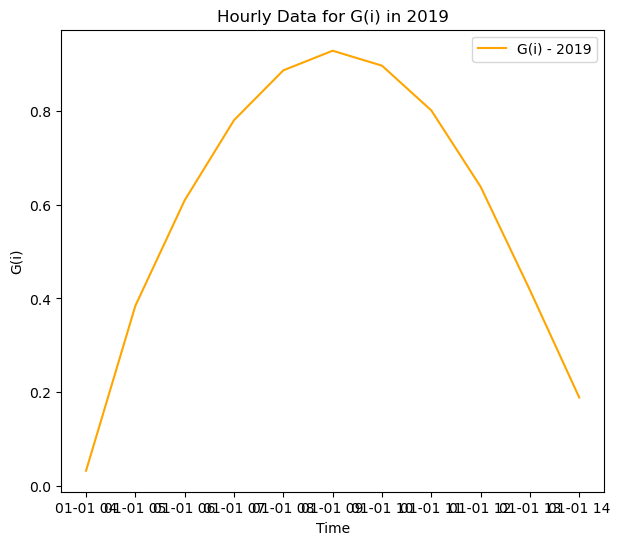

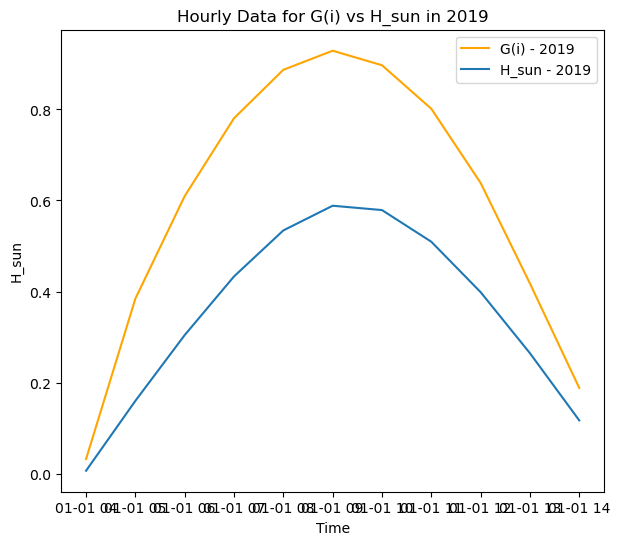

In [6]:
# TODO Merhawi
# this for hourly basis
# Now resample to hourly intervals
data_hourly = data.resample('H').mean()

# Verify index is DatetimeIndex
print(data_hourly.head(10))

# Continue with plotting code as before
# Get unique years in the dataset
#years = data_hourly.index.year.unique()



data_2019 = data_hourly[(data_hourly.index.year == 2019) & (data_hourly.index.month == 1) &
                        (data_hourly.index.day == 1)]
print(data_2019)

# this is plot for G (i) vesrus wiht h_sun
plt.figure(figsize=(7,6))
plt.plot(data_2019.index, data_2019['G(i)'], color='orange', label='G(i) - 2019')
plt.title('Hourly Data for G(i) in 2019')
plt.xlabel('Time')
plt.ylabel('G(i)')
plt.legend()
plt.show()
    

plt.figure(figsize=(7, 6))
plt.plot(data_2019.index, data_2019['G(i)'], color='orange', label='G(i) - 2019')
plt.plot(data_2019.index, data_2019['H_sun'], label='H_sun - 2019')
plt.title('Hourly Data for G(i) vs H_sun in 2019')
plt.xlabel('Time')
plt.ylabel('H_sun')
plt.legend()
plt.show()

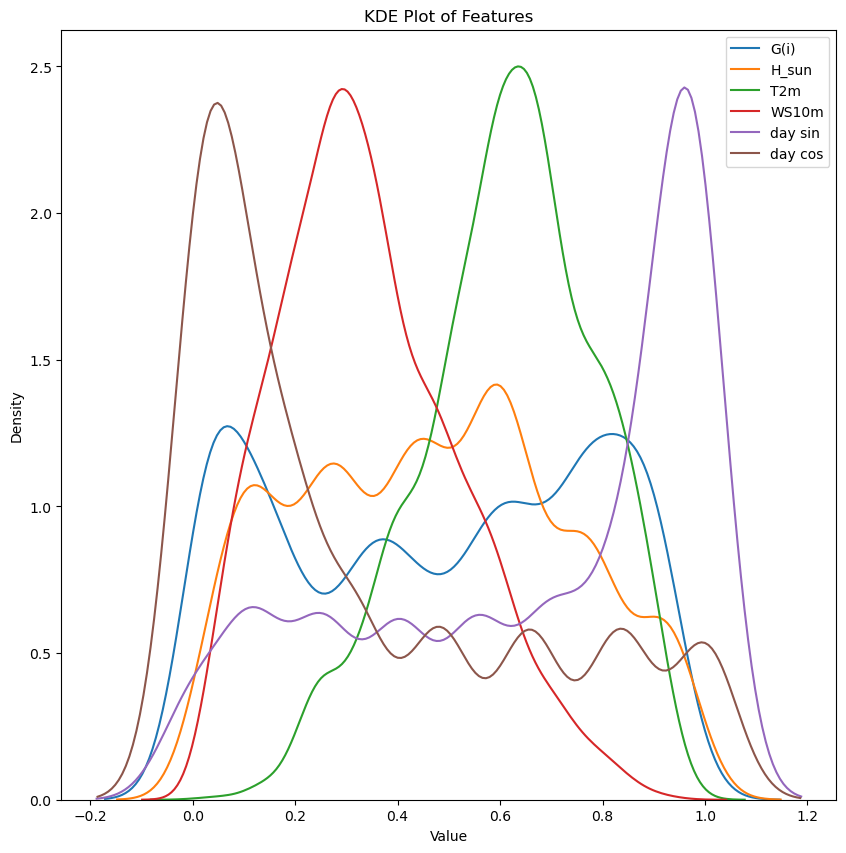

In [7]:
data.drop(['Season'], axis=1, inplace=True)
data_2019 = data[(data.index.year == 2019)]
# Additional KDE Plot for each feature to observe distribution
plt.figure(figsize=(10, 10))
for column in data_2019.columns:
    sns.kdeplot(data_2019[column] , label=column)
plt.title('KDE Plot of Features')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()


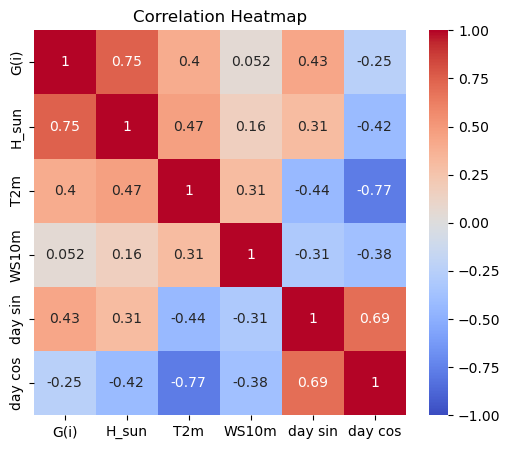

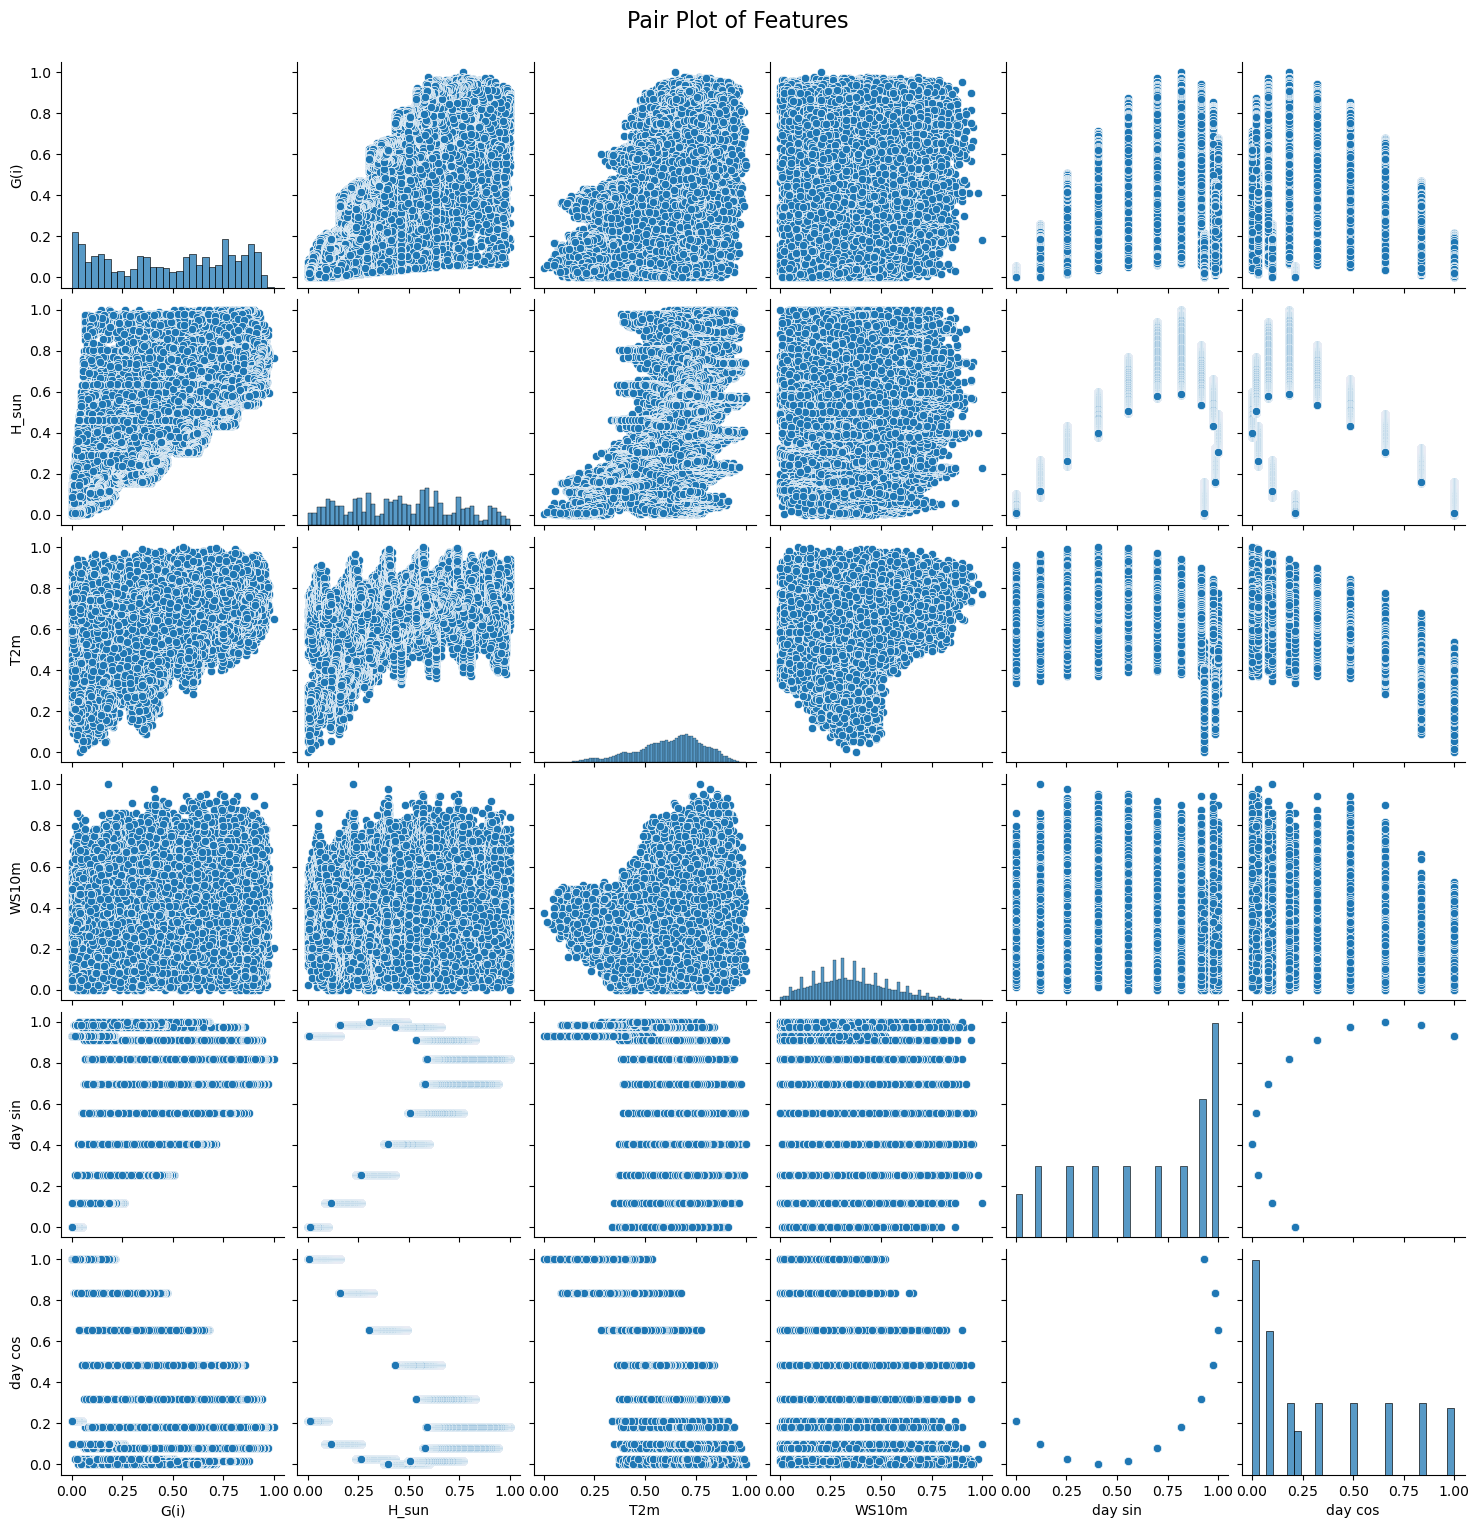

In [8]:
 ## Correlation Analysis
# Correlation Heatmap
plt.figure(figsize=(6, 5))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

# Pair Plot for Visualizing Relationships Between Features
sns.pairplot(data, palette='bright')
plt.suptitle('Pair Plot of Features', y=1.02, fontsize=16)
plt.show()


In [9]:
df = df.dropna(subset=['time']) 
df['time'].tail(20)

time
2020-12-30 06:07:00    20201230:0607
2020-12-30 07:07:00    20201230:0707
2020-12-30 08:07:00    20201230:0807
2020-12-30 09:07:00    20201230:0907
2020-12-30 10:07:00    20201230:1007
2020-12-30 11:07:00    20201230:1107
2020-12-30 12:07:00    20201230:1207
2020-12-30 13:07:00    20201230:1307
2020-12-30 14:07:00    20201230:1407
2020-12-31 04:07:00    20201231:0407
2020-12-31 05:07:00    20201231:0507
2020-12-31 06:07:00    20201231:0607
2020-12-31 07:07:00    20201231:0707
2020-12-31 08:07:00    20201231:0807
2020-12-31 09:07:00    20201231:0907
2020-12-31 10:07:00    20201231:1007
2020-12-31 11:07:00    20201231:1107
2020-12-31 12:07:00    20201231:1207
2020-12-31 13:07:00    20201231:1307
2020-12-31 14:07:00    20201231:1407
Name: time, dtype: object

In [10]:
df = df[:96431:]  # Truncate the DataFrame to include only the first 96,431 rows.

df.drop(['Int', 'time'], axis = 1,inplace=True)
df_multi = df.iloc[:,:]  # Select columns from index 1 to 4 (inclusive), typically removing the time column assuming it's at index 0.

df.tail(30)  # Display the last 30 rows of the DataFrame to check the end of the dataset.

print(df_multi.head(10))  # Print the first 10 rows of the subset DataFrame to verify the correct columns and data.

print(df_multi.dtypes)  # Print the data types of the columns in the subset DataFrame to ensure they are appropriate for further analysis.


                        G(i)  H_sun    T2m  WS10m   day sin   day cos  Season
time                                                                         
2010-01-01 04:07:00    91.98   2.76   9.77   1.93  0.880891  0.473320       1
2010-01-01 05:07:00   432.28  15.67  11.48   1.72  0.973379  0.229200       1
2010-01-01 06:07:00   681.34  27.82  15.42   1.72  0.999534 -0.030539       1
2010-01-01 07:07:00   867.69  38.65  19.13   1.72  0.957571 -0.288196       1
2010-01-01 08:07:00   987.62  47.15  21.08   1.66  0.850352 -0.526214       1
2010-01-01 09:07:00  1034.38  51.71  22.13   1.24  0.685183 -0.728371       1
2010-01-01 10:07:00   998.94  50.91  23.35   0.76  0.473320 -0.880891       1
2010-01-01 11:07:00   887.09  45.06  23.95   0.28  0.229200 -0.973379       1
2010-01-01 12:07:00   702.60  35.75  24.15   0.21 -0.030539 -0.999534       1
2010-01-01 13:07:00   472.43  24.47  23.86   0.48 -0.288196 -0.957571       1
G(i)       float64
H_sun      float64
T2m        float64
WS10m  

In [11]:
# ToDo Merhawi Check the result by using MinMaxScaler() 
# Initialize MinMaxScaler
scaler = StandardScaler() 

# Fit and transform the data
scaled_data = scaler.fit_transform(df_multi)

# Create a new DataFrame with scaled data, preserving column names and index
scaled_df = pd.DataFrame(scaled_data, columns=df_multi.columns, index=df_multi.index)

# Display the first few rows and basic statistics to confirm
print(scaled_df.head())

                         G(i)     H_sun       T2m     WS10m   day sin  \
time                                                                    
2010-01-01 04:07:00 -1.358802 -1.767520 -2.896853 -0.206566  0.822914   
2010-01-01 05:07:00 -0.370848 -1.180647 -2.549302 -0.399310  0.983538   
2010-01-01 06:07:00  0.352219 -0.628322 -1.748514 -0.399310  1.028960   
2010-01-01 07:07:00  0.893228 -0.136003 -0.994471 -0.399310  0.956085   
2010-01-01 08:07:00  1.241407  0.250397 -0.598142 -0.454379  0.769878   

                      day cos    Season  
time                                     
2010-01-01 04:07:00  2.051249 -1.372967  
2010-01-01 05:07:00  1.546411 -1.372967  
2010-01-01 06:07:00  1.009271 -1.372967  
2010-01-01 07:07:00  0.476435 -1.372967  
2010-01-01 08:07:00 -0.015785 -1.372967  


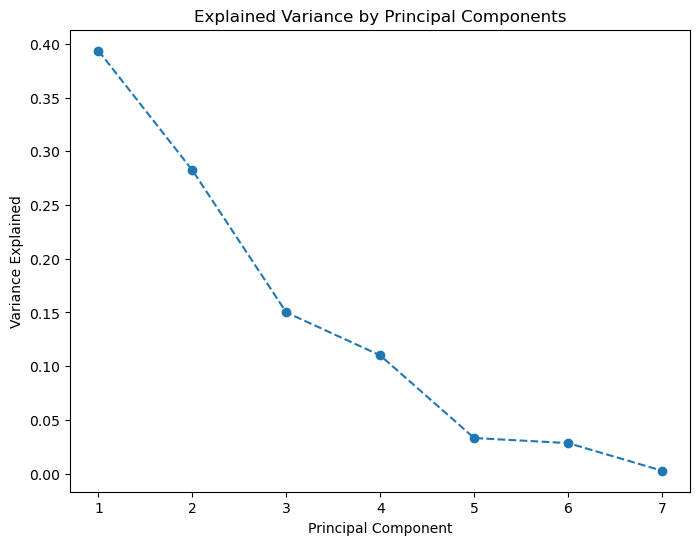

Explained variance by each principal component:
Principal Component 1: 0.39
Principal Component 2: 0.28
Principal Component 3: 0.15
Principal Component 4: 0.11
Principal Component 5: 0.03
Principal Component 6: 0.03
Principal Component 7: 0.00
Principal Components:
       G(i)     H_sun       T2m     WS10m   day sin   day cos    Season
0 -0.317600 -0.388412 -0.538338 -0.305774  0.254348  0.543199  0.072132
1 -0.550984 -0.474626  0.052223  0.188731 -0.623446 -0.209327 -0.017226
2  0.095906 -0.179687  0.028550  0.170289  0.086020  0.137607 -0.949930
3 -0.050626  0.077936 -0.264943  0.910975  0.177018  0.170076  0.176156
4 -0.206122  0.482755 -0.684081 -0.104801 -0.125991 -0.423507 -0.224233
5 -0.709291  0.471779  0.406652 -0.026278  0.222724  0.220017 -0.101300
6 -0.195463 -0.360385  0.055881  0.018309  0.665137 -0.620879  0.023687


In [12]:
pca = PCA(n_components=None)  # Setting n_components=None keeps all components
pca.fit(scaled_df)

# Step 3: Transform the data
data_pca = pca.transform(scaled_df)

# Step 4: Explained variance plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('Explained Variance by Principal Components')
plt.show()

# Print the explained variance of each component
print("Explained variance by each principal component:")
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f"Principal Component {i + 1}: {var:.2f}")

# Step 5: Optionally, you can create a DataFrame of the PCA components
# This shows how much each original feature contributes to each principal component
pca_df = pd.DataFrame(pca.components_, columns=df_multi.columns)
print("Principal Components:")
print(pca_df)

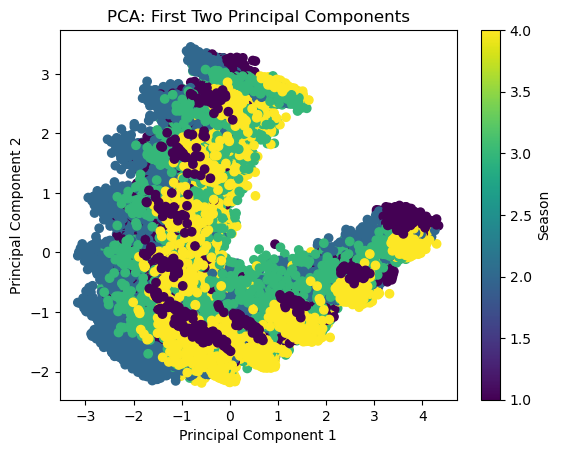

In [13]:
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=df_multi['Season'], cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Season')
plt.title('PCA: First Two Principal Components')
plt.show()

In [14]:
def df_to_X_y(df_as_np, window_size=5):
#   df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [a for a in df_as_np[i:i+window_size,:]]
    X.append(row)
    label = df_as_np[i+window_size,0]
    y.append(label)
  return np.array(X), np.array(y)

In [15]:
WINDOW_SIZE = 24 
df_scaled = scaled_df.to_numpy()
X1, y1 = df_to_X_y(df_scaled, WINDOW_SIZE)
print(X1[0])
print("#############################")
print(y1[0])
X1.shape, y1.shape

[[-1.35880186 -1.76752009 -2.89685276 -0.20656631  0.82291365  2.05124875
  -1.37296658]
 [-0.37084797 -1.1806466  -2.5493023  -0.3993095   0.98353813  1.54641058
  -1.37296658]
 [ 0.3522193  -0.62832181 -1.74851351 -0.3993095   1.02896026  1.00927104
  -1.37296658]
 [ 0.89322785 -0.13600268 -0.99447128 -0.3993095   0.95608461  0.47643531
  -1.37296658]
 [ 1.24140683  0.25039738 -0.59814181 -0.45437899  0.76987753 -0.01578473
  -1.37296658]
 [ 1.37715977  0.45768964 -0.38473363 -0.83986538  0.48302872 -0.4338451
  -1.37296658]
 [ 1.27427089  0.42132258 -0.13677365 -1.28042126  0.11508645 -0.74925568
  -1.37296658]
 [ 0.94954964  0.15538842 -0.01482612 -1.72097713 -0.30887461 -0.94052175
  -1.37296658]
 [ 0.41394102 -0.26783329  0.02582306 -1.78522486 -0.75996222 -0.99460886
  -1.37296658]
 [-0.25428509 -0.78060889 -0.03311825 -1.53741218 -1.2074355  -0.90783105
  -1.37296658]
 [-1.01915823 -1.34475297 -0.17132545 -1.40891672 -1.6207999  -0.68610209
  -1.37296658]
 [-1.57421819 -1.77070

((46163, 24, 7), (46163,))

In [16]:
df_winter = scaler.transform(df_multi[df_multi['Season'] == 1])
df_spring = scaler.transform(df_multi[df_multi['Season'] == 2])
df_summer = scaler.transform(df_multi[df_multi['Season'] == 3])
df_fall = scaler.transform(df_multi[df_multi['Season'] == 4])
df_winter

array([[-1.35880186, -1.76752009, -2.89685276, ...,  0.82291365,
         2.05124875, -1.37296658],
       [-0.37084797, -1.1806466 , -2.5493023 , ...,  0.98353813,
         1.54641058, -1.37296658],
       [ 0.3522193 , -0.62832181, -1.74851351, ...,  1.02896026,
         1.00927104, -1.37296658],
       ...,
       [ 0.46965314, -0.2751067 ,  0.92010495, ..., -0.75996222,
        -0.99460886, -1.37296658],
       [-0.21204375, -0.78833689,  0.81035217, ..., -1.2074355 ,
        -0.90783105, -1.37296658],
       [-0.98281036, -1.35202639,  0.59287907, ..., -1.6207999 ,
        -0.68610209, -1.37296658]])

In [17]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(df_scaled, WINDOW_SIZE)
X_winter, y_winter = df_to_X_y(df_winter, WINDOW_SIZE)
X_spring, y_spring = df_to_X_y(df_spring, WINDOW_SIZE)
X_summer, y_summer = df_to_X_y(df_summer, WINDOW_SIZE)
X_fall, y_fall = df_to_X_y(df_fall, WINDOW_SIZE)
X1, y1 = df_to_X_y(df_scaled, WINDOW_SIZE)

In [18]:
X_train1, y_train1 = X1[:30684], y1[:30684] 
X_val1, y_val1 = X1[30685:35064], y1[30685:35064] # 1 year for validation [61,367 , 70127]
X_test1, y_test1 = X1[35065:], y1[35065:] #  1 year testing [70,128 , 78887]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((30684, 5, 7), (30684,), (4379, 5, 7), (4379,), (11117, 5, 7), (11117,))

In [19]:

# Define custom metrics
def mae(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))

def mba(y_true, y_pred):
    return K.mean(K.abs(K.mean(y_pred - y_true)))

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))  # Root Mean Squared Error

# Define model-building function for Keras Tuner
def build_model(hp):
    model = Sequential()

    # First LSTM layer
    model.add(LSTM(units=hp.Int('units_1', min_value=32, max_value=128, step=32), 
                   return_sequences=True, input_shape=(5, 7)))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))

    # Second LSTM layer
    model.add(LSTM(units=hp.Int('units_2', min_value=32, max_value=128, step=32), 
                   return_sequences=True))
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))

    # Third LSTM layer (using Bidirectional)
    model.add(Bidirectional(LSTM(units=hp.Int('units_3', min_value=32, max_value=128, step=32), 
                                 return_sequences=False)))
    model.add(Dropout(rate=hp.Float('dropout_3', min_value=0.2, max_value=0.5, step=0.1)))

    # Fully connected layer
    model.add(Dense(units=hp.Int('dense_units', min_value=32, max_value=128, step=32), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_4', min_value=0.2, max_value=0.5, step=0.1)))

    # Output layer
    model.add(Dense(1))  # Adjust output layer based on your task (e.g., regression or classification)

    # Compile the model with custom metrics
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss=MeanSquaredError(),
        metrics=[mae, mba, rmse]
    )

    return model

# Set up Keras Tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=10,
    factor=3,
    directory='kt_dir',
    project_name='lstm_tuning'
)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=20, verbose=1, mode='min')
cp1 = ModelCheckpoint('model_G(I)/model_all_stdscalled_best.keras', save_best_only=True)

# Perform the hyperparameter search
tuner.search(
    X_train1, y_train1,
    epochs=50,
    validation_data=(X_val1, y_val1),
    callbacks=[early_stopping, cp1]
)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# You can print the best hyperparameters as well
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:", best_hyperparameters.values)

# Fit the best model on the full dataset
history_lstm = best_model.fit(
    X_train1, y_train1,
    validation_data=(X_val1, y_val1),
    epochs=50,
    callbacks=[early_stopping, cp1]
)


Reloading Tuner from kt_dir/lstm_tuning/tuner0.json
Best hyperparameters: {'units_1': 96, 'dropout_1': 0.2, 'units_2': 128, 'dropout_2': 0.2, 'units_3': 64, 'dropout_3': 0.2, 'dense_units': 96, 'dropout_4': 0.2, 'learning_rate': 0.0002547058830536625, 'tuner/epochs': 10, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
Epoch 1/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.1029 - mae: 1.0936 - mba: 0.0474 - rmse: 1.3518 - val_loss: 0.0987 - val_mae: 1.0435 - val_mba: 0.0613 - val_rmse: 1.2949
Epoch 2/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.1057 - mae: 1.0942 - mba: 0.0480 - rmse: 1.3534 - val_loss: 0.0975 - val_mae: 1.0504 - val_mba: 0.0524 - val_rmse: 1.3040
Epoch 3/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.1002 - mae: 1.0919 - mba: 0.0436 - rmse: 1.3510 - val_loss: 0.0973 - val_mae: 1.0416 - val_mba: 0.0552 - val_rmse: 1.2909
Epoch 4/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.1028 - mae: 1.1019 - mba: 0.0481 - rmse: 1.3622 - 

In [20]:
test_loss, test_mae, test_mba, test_rmse = best_model.evaluate(X_test1, y_test1)
print(f'Test MAE: {test_mae}, Test MBA: {test_mba}, Test RMAE: {test_rmse}%')

348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1059 - mae: 1.0287 - mba: 0.0524 - rmse: 1.2759
Test MAE: 1.0312644243240356, Test MBA: 0.05243230611085892, Test RMAE: 1.2807120084762573%


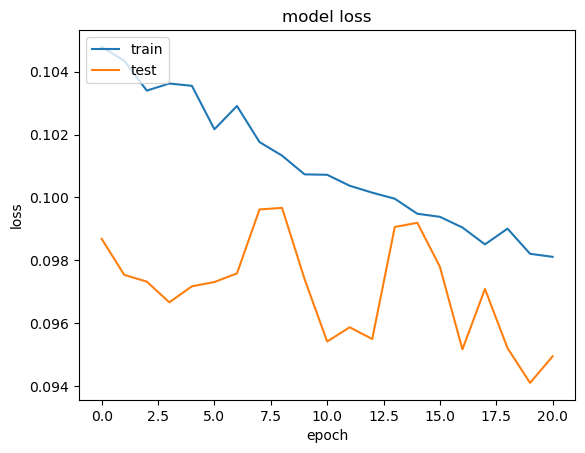

In [21]:
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0442 - mae: 1.0785 - mba: 0.0398 - rmse: 1.3495
Test MAE: winter, Test MBA: 0.042343512177467346, Test RMAE: 1.3482578992843628%
378/378 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
378/378 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1441 - mae: 0.9363 - mba: 0.0513 - rmse: 1.1592
Test MAE: summer, Test MBA: 0.052754685282707214, Test RMAE: 1.1522071361541748%
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0696 - mae: 1.1160 - mba: 0.0375 - rmse: 1.3845
Test MAE: spring, Test MBA: 0.04011103883385658, Test RMAE: 1.374956727027893%
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1048 - mae: 1.0779 - mba: 0.0505 - rmse: 1.3352
Test MAE: fall, Test MBA: 0.050901565700769424, Test RMAE: 1.3311361074447632%


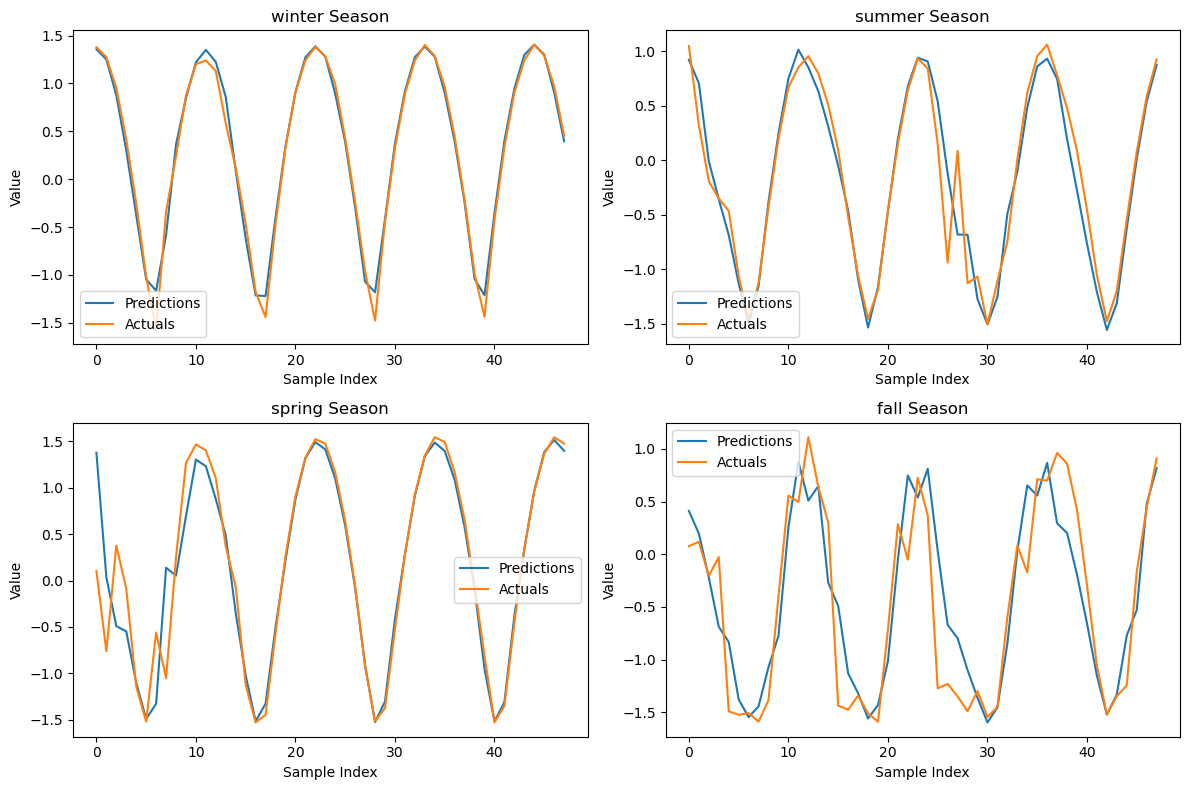

In [22]:
season_list_x = [X_winter, X_summer, X_spring,X_fall] 
season_list_y = [y_winter, y_summer, y_spring,y_fall] 
season_names = ["winter","summer","spring","fall"]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()  

for idx, (i, j) in enumerate(zip(season_list_x, season_list_y)):
    train_predictions = best_model.predict(i).flatten()
    train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':j.flatten()})
    test_loss, test_mae, test_mba, test_rmae = best_model.evaluate(i, j)
    print(f'Test MAE: {season_names[idx]}, Test MBA: {test_mba}, Test RMAE: {test_rmae}%')
    ax = axes[idx]
    ax.plot(train_results['Train Predictions'][0:48], label='Predictions')
    ax.plot(train_results['Actuals'][0:48], label='Actuals')
    ax.set_title(f"{season_names[idx]} Season")
    ax.legend()
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Value')


plt.tight_layout()
plt.show()
    

In [23]:
# Define model-building function for Keras Tuner
def build_gru_model(hp):
    model = Sequential()
    model.add(InputLayer(input_shape=(5, 7)))  # Assuming input shape (5, 7) (or whatever shape you have)

    # Add a stack of GRU layers with increasing complexity
    model.add(GRU(units=hp.Int('gru_units_1', min_value=32, max_value=128, step=32), 
                  return_sequences=True))  # First GRU layer
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))  # Dropout

    model.add(GRU(units=hp.Int('gru_units_2', min_value=32, max_value=128, step=32), 
                  return_sequences=True))  # Second GRU layer
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))  # Dropout

    model.add(GRU(units=hp.Int('gru_units_3', min_value=32, max_value=128, step=32)))  # Final GRU layer
    model.add(Dropout(rate=hp.Float('dropout_3', min_value=0.2, max_value=0.5, step=0.1)))  # Dropout

    # Dense layers to increase model complexity
    model.add(Dense(units=hp.Int('dense_units_1', min_value=8, max_value=64, step=8), activation='relu'))  # Dense layer
    model.add(Dropout(rate=hp.Float('dropout_4', min_value=0.2, max_value=0.5, step=0.1)))  # Dropout

    model.add(Dense(units=hp.Int('dense_units_2', min_value=8, max_value=64, step=8), activation='relu'))  # Dense layer

    # Output layer for regression
    model.add(Dense(1, activation='linear'))

    # Compile the model with custom metrics
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss=MeanSquaredError(),
        metrics=[mae, mba, rmse]
    )

    return model

# Set up Keras Tuner
tuner = kt.Hyperband(
    build_gru_model,
    objective='val_loss',
    max_epochs=10,
    factor=3,
    directory='kt_gru_dir',
    project_name='gru_tuning'
)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=20, verbose=1, mode='min')
cp1 = ModelCheckpoint('model_G(I)/gru_model_best.keras', save_best_only=True)

# Perform the hyperparameter search
tuner.search(
    X_train1, y_train1,
    epochs=50,
    validation_data=(X_val1, y_val1),
    callbacks=[early_stopping, cp1]
)

# Get the best model
best_model_gru = tuner.get_best_models(num_models=1)[0]

# You can print the best hyperparameters as well
best_hyperparameters_gru = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:", best_hyperparameters_gru.values)

# Fit the best model on the full dataset
history_gru = best_model_gru.fit(
    X_train1, y_train1,
    validation_data=(X_val1, y_val1),
    epochs=50,
    callbacks=[early_stopping, cp1]
)

Reloading Tuner from kt_gru_dir/gru_tuning/tuner0.json
Best hyperparameters: {'gru_units_1': 64, 'dropout_1': 0.2, 'gru_units_2': 64, 'dropout_2': 0.4, 'gru_units_3': 96, 'dropout_3': 0.2, 'dense_units_1': 48, 'dropout_4': 0.2, 'dense_units_2': 8, 'learning_rate': 0.0003711901475345014, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0012'}
Epoch 1/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.1107 - mae: 1.0901 - mba: 0.0502 - rmse: 1.3476 - val_loss: 0.1026 - val_mae: 1.0275 - val_mba: 0.0663 - val_rmse: 1.2718
Epoch 2/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1079 - mae: 1.0964 - mba: 0.0472 - rmse: 1.3551 - val_loss: 0.1099 - val_mae: 1.0139 - val_mba: 0.0869 - val_rmse: 1.2511
Epoch 3/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1081 - mae: 1.0971 - mba: 0.0480 - rmse: 1.3567 - val_loss: 0.1046 - val_mae: 1.0155 - val_mba: 0.0617 - val_rmse: 1.2558
Epoch 4/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/ste

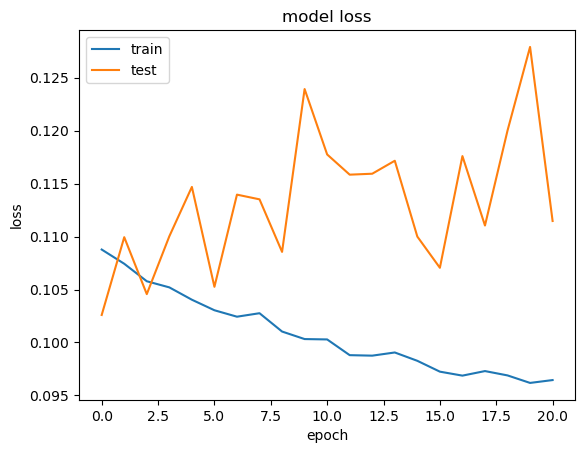

In [24]:
plt.plot(history_gru.history['loss'])
plt.plot(history_gru.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - loss: 0.0635 - mae: 1.0228 - mba: 0.0780 - rmse: 1.2678
Test MAE: winter, Test MBA: 0.08043753355741501, Test RMAE: 1.2666339874267578%
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - loss: 0.1536 - mae: 0.9025 - mba: 0.0762 - rmse: 1.1084
Test MAE: summer, Test MBA: 0.07916466891765594, Test RMAE: 1.1022424697875977%
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - loss: 0.0856 - mae: 1.0586 - mba: 0.0714 - rmse: 1.3034
Test MAE: spring, Test MBA: 0.07259158045053482, Test RMAE: 1.2953310012817383%
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - loss: 0.1192 - mae: 1.0246 - mba: 0.0821 - rmse: 1.2598
Test MAE: fall, Test MBA: 0.08338622748851776, Test RMAE: 1.256058931350708%


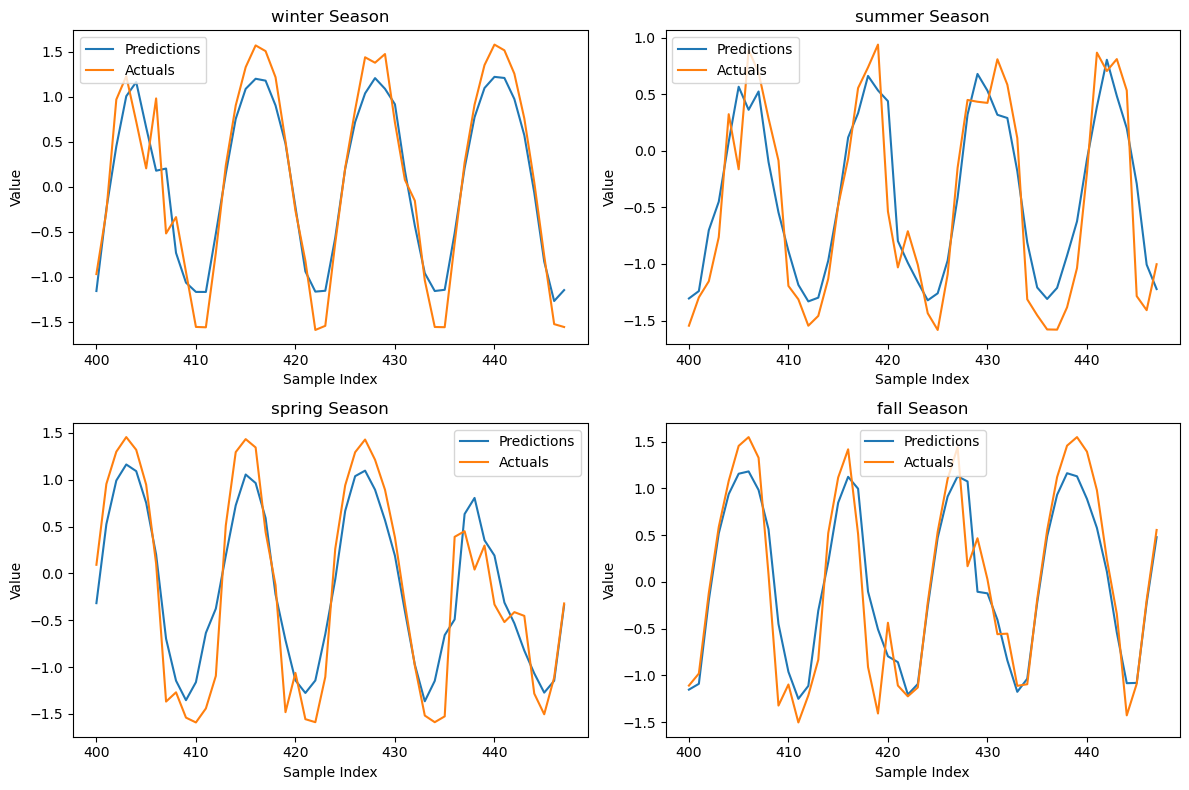

In [25]:
season_list_x = [X_winter, X_summer, X_spring,X_fall] 
season_list_y = [y_winter, y_summer, y_spring,y_fall] 
season_names = ["winter","summer","spring","fall"]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()  

for idx, (i, j) in enumerate(zip(season_list_x, season_list_y)):
    train_predictions = best_model_gru.predict(i).flatten()
    train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':j.flatten()})
    test_loss, test_mae, test_mba, test_rmae = best_model_gru.evaluate(i, j)
    print(f'Test MAE: {season_names[idx]}, Test MBA: {test_mba}, Test RMAE: {test_rmae}%')
    ax = axes[idx]
    ax.plot(train_results['Train Predictions'][400:448], label='Predictions')
    ax.plot(train_results['Actuals'][400:448], label='Actuals')
    ax.set_title(f"{season_names[idx]} Season")
    ax.legend()
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Value')


plt.tight_layout()
plt.show()

In [35]:
# Define a custom Residual Block with projection to match input and output shapes
class ResidualBlock(layers.Layer):
    def __init__(self, filters, kernel_size, dilation_rate, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.conv1 = Conv1D(filters=filters, kernel_size=kernel_size, padding='causal', dilation_rate=dilation_rate)
        self.relu1 = ReLU()
        self.conv2 = Conv1D(filters=filters, kernel_size=kernel_size, padding='causal', dilation_rate=dilation_rate)
        self.relu2 = ReLU()
        self.add = Add()
        
        # Projection layer to match input and output shapes if needed
        self.projection = Conv1D(filters=filters, kernel_size=1, padding='same') if filters != 64 else None
    
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.relu1(x)
        x = self.conv2(x)
        
        # Project input if necessary to match the shape
        if self.projection is not None:
            inputs = self.projection(inputs)
        
        # Ensure input and output shapes match before adding them
        if x.shape[1:] != inputs.shape[1:]:
            raise ValueError(f"Input and output shapes don't match: {x.shape} vs {inputs.shape}")
        
        x = self.add([inputs, x])  # Residual connection
        x = self.relu2(x)
        return x

# Define the model-building function for Keras Tuner
def build_model(hp):
    # Input shape for your data
    input_shape = (5, 7)  # Update this as per your data
    inputs = Input(shape=input_shape)
    
    # LSTM Layers
    x = LSTM(256, return_sequences=True)(inputs)
    x = LSTM(128, return_sequences=True)(x)
    x = LSTM(64, return_sequences=True)(x)
    
    # Residual Blocks with increasing dilation rates (dilation_rate is tunable)
    for dilation_rate in [1, 2, 4]:
        x = ResidualBlock(
            filters=hp.Int('conv_filters', min_value=64, max_value=128, step=32),
            kernel_size=hp.Int('kernel_size', min_value=3, max_value=5, step=1),
            dilation_rate=dilation_rate
        )(x)
    
    # Fully Connected (Dense) Layer
    x = Dense(units=1, activation='linear')(x)  # Assuming a single output for regression
    
    # Model creation
    model = Model(inputs=inputs, outputs=x)
    
    # Compile the model
    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']),
        loss='mse',  # Mean Squared Error for regression
        metrics=[mae, mba, rmse]
    )
    return model

# Set up the Keras Tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=50,
    hyperband_iterations=2,
    directory='my_dir',
    project_name='tuner_project'
)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=1, mode='min')
model_checkpoint = ModelCheckpoint('model_G(I)/gru_model_best.keras', save_best_only=True)

# Start the search for the best model
tuner.search(X_train1, y_train1, epochs=50, validation_data=(X_val1, y_val1), callbacks=[early_stopping, model_checkpoint])

# Retrieve the best model
best_hybrid_model = tuner.get_best_models(num_models=1)[0]

# Model summary of the best model
best_hybrid_model.summary()

# You can print the best hyperparameters as well
best_hyperparameters_hybrid = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:", best_hyperparameters_hybrid.values)

# Fit the best model on the full dataset
history_hybrid = best_hybrid_model.fit(
    X_train1, y_train1,
    validation_data=(X_val1, y_val1),
    epochs=50,
    callbacks=[early_stopping, model_checkpoint]
)


Reloading Tuner from my_dir/tuner_project/tuner0.json


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5, 7)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 5, 256)         │       270,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 5, 128)         │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 5, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block (ResidualBlock)  │ (None, 5, 64)          │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_1                │ (None, 5, 64)          │        32,896 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_2                │ (None, 5, 64)          │        32,896 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5, 1)           │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 615,617 (2.35 MB)

 Trainable params: 615,617 (2.35 MB)

 Non-trainable params: 0 (0.00 B)

Best hyperparameters: {'conv_filters': 64, 'kernel_size': 4, 'optimizer': 'adam', 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 3, 'tuner/round': 0}
Epoch 1/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 1.0016 - mae: 0.8875 - mba: 0.1410 - rmse: 0.9983 - val_loss: 1.0060 - val_mae: 0.8887 - val_mba: 0.2893 - val_rmse: 1.0004
Epoch 2/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 1.0028 - mae: 0.8872 - mba: 0.1405 - rmse: 0.9989 - val_loss: 1.0047 - val_mae: 0.8901 - val_mba: 0.2906 - val_rmse: 0.9997
Epoch 3/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 1.0068 - mae: 0.8917 - mba: 0.1436 - rmse: 1.0010 - val_loss: 1.0029 - val_mae: 0.8885 - val_mba: 0.2866 - val_rmse: 0.9988
Epoch 4/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 1.0012 - mae: 0.8861 - mba: 0.1448 - rmse: 0.9977 - val_loss: 1.0049 - val_mae: 0.8904 - val_mba: 0.2909 - val_rmse: 0.9998
Epoch 5/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 1.0059 - mae: 0.8912 - mba: 0

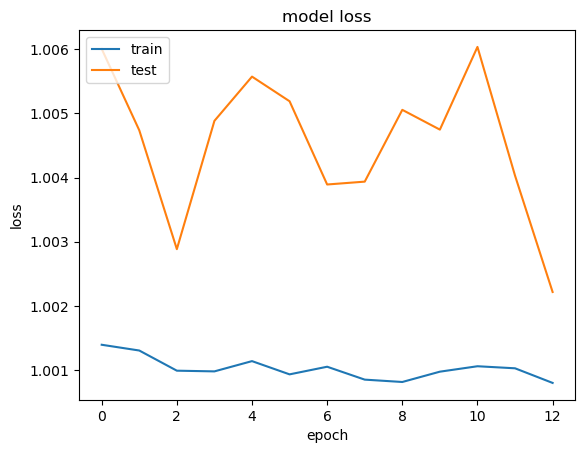

In [36]:
plt.plot(history_hybrid.history['loss'])
plt.plot(history_hybrid.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


ValueError: All arrays must be of the same length

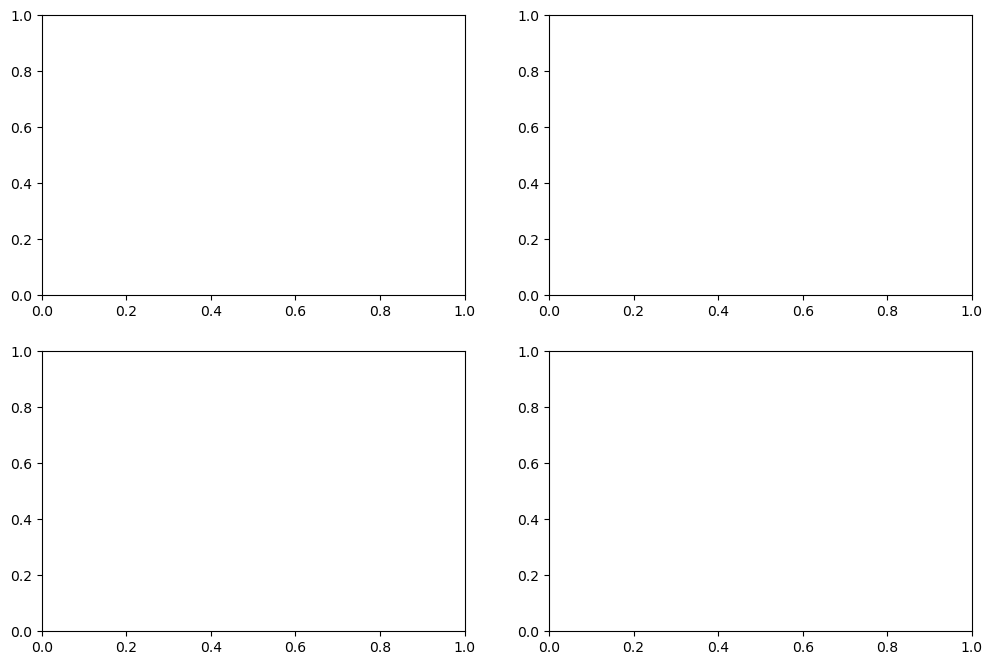

In [37]:
season_list_x = [X_winter, X_summer, X_spring, X_fall] 
season_list_y = [y_winter, y_summer, y_spring, y_fall] 
season_names = ["winter", "summer", "spring", "fall"]

# Create a 2x2 plot grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()

# Loop through each season and plot predictions vs actual values
for idx, (X_season, y_season) in enumerate(zip(season_list_x, season_list_y)):
    # Ensure the model is predicting correctly
    # Predict the values for the current season
    train_predictions = best_hybrid_model.predict(X_season)
    
    # Flatten the predictions and actual values (if needed)
    train_predictions = train_predictions.flatten()
    y_season = y_season.flatten()

    # Create a DataFrame for easier comparison
    train_results = pd.DataFrame(data={'Train Predictions': train_predictions, 'Actuals': y_season})

    # Plot the first 250 samples for better visualization
    ax = axes[idx]
    ax.plot(train_results['Train Predictions'][:250], label='Predictions', color='blue')
    ax.plot(train_results['Actuals'][:250], label='Actuals', color='orange')

    # Set title, labels, and legend
    ax.set_title(f"{season_names[idx]} Season")
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Value')
    ax.legend()

# Improve layout for clarity
plt.tight_layout()
plt.show()